<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v2/blob/main/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# notebook start time
import time
import datetime
import pytz

start_time = time.time()

# function to print date timestamp
def print_date_time():
  tz_NY = pytz.timezone('Asia/Kolkata')
  datetime_NY = datetime.datetime.now(tz_NY)
  print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

print_date_time()

Run date time (IST): 2024-07-27 14:09:54


In [2]:
# function to get booked and reserved amount
def get_amt():
  py_booked_amt = 304000 + 1007000
  cy_booked_amt = 225000 + 214000
  reserve_amt = 156000 + 282
  total_booked_amt = py_booked_amt + cy_booked_amt
  return total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt

total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

gen_output = 0

In [3]:
# install libraries
!pip install pyxirr
#!pip install talib-binary

In [4]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin

from google.colab import data_table

In [5]:
# function to format the amount
def format_amt(number):
    abs_number = abs(number)

    if abs_number >= 1_00_00_000:  # Crores
        formatted_amt = f"{number / 1_00_00_000:.2f} C"
    elif abs_number >= 1_00_000:  # Lakhs
        formatted_amt = f"{number / 1_00_000:.2f} L"
    elif abs_number >= 1_000:  # Thousands
        formatted_amt = f"{number / 1_000:.2f} K"
    else:
        formatted_amt = f"{number:.2f}"

    return formatted_amt

# function to set start and end date
def get_start_end_date():
  start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
  end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
  return start_date, end_date

# function to fetch my portfolio csv
def get_mypfs_df():
  mypfs_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myPortfolioStocks.csv')
  return mypfs_df

# function to fetch my prospects csv
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')
  return mypps_df

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df

# function to fetch xirr data
def get_myxirr_df():
  myxirr_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myStocks-XIRR.csv')
  return myxirr_df

# function to fetch momentum data
def get_mymmtm_df():
  mymmtm_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspects-Momentum.csv')
  return mymmtm_df

# function to fetch momentum data
def get_myinvmt_df():
  myinvmt_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
  return myinvmt_df

# function to get the stock ids
def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC', 'MASFIN']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

# get features from screener data
def get_screener_features():
  myscreen_df = get_myscreen_df()
  cols = ['Symbol', 'EPS', 'MedPE', 'ROCE%', 'ROE%', 'CapType']
  return myscreen_df[cols]

In [6]:
# function to get stock technicals
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = yfin.Ticker(stock_symbol + '.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Symbol'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Prev_Close'] = stock_df['Close'].shift(1)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
    stock_df = stock_df.tail(1)

    return stock_df

# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):

  df_prec_dev = pd.DataFrame()
  df_tmp = get_screener_features()

  for stock_id in stock_ids:
      tmp = stock_prec_dev(stock_id)
      tmp = tmp.reset_index()
      df_prec_dev = pd.concat([df_prec_dev, tmp], ignore_index = True)
  df_prec_dev = pd.merge(df_prec_dev, df_mypf, on= 'Symbol')
  df_prec_dev = pd.merge(df_prec_dev, df_tmp, on= 'Symbol', how='left')
  df_prec_dev = pd.merge(df_prec_dev, myxirr_df, on= 'Symbol', how='left')
  df_prec_dev = pd.merge(df_prec_dev, mymmtm_df, on= 'Symbol', how='left')
  #print(df_prec_dev.columns)
  df_prec_dev['Curr_PE'] = round(df_prec_dev['Close']/df_prec_dev['EPS'],1)
  df_prec_dev['Dev%_PE'] = round((df_prec_dev['Curr_PE'] - df_prec_dev['MedPE'])*100/df_prec_dev['MedPE'],2)
  return df_prec_dev

# function to arrange stock features
def arrange_features(df_stocks, common_cols, diff_cols):
  df_stocks_common = df_stocks[common_cols].drop_duplicates()
  df_stocks_diff = df_stocks[diff_cols]
  df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
  df_stocks_diff = df_stocks_diff.groupby(['Symbol'])[['Shares', 'Investment']].aggregate(['sum']).reset_index()
  df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
  df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
  df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')
  return df_stocks

In [7]:
# function to get portfolio features

def get_portfolio_features(df_common_features):

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['NTT'] = np.where(df_common_features['Strategy']== 'NTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['LTT'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['BOL'] = df_common_features['Min']

  tmp_df = df_common_features[df_common_features['Symbol'].isin(mypf_df[mypf_df['InPortfolio'] != 'NA'].Symbol.values)]
  print('qualified stocks: '+str(len(tmp_df['Symbol'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df['Investment'] = tmp_df['AvgCost'] * tmp_df['Shares']
  tmp_df['Current'] = round(tmp_df['Close'] * tmp_df['Shares'],0)
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['EstimatedST'] = tmp_df['NTT'] * tmp_df['Shares']
  tmp_df['EstimatedLT'] = tmp_df['LTT'] * tmp_df['Shares']
  tmp_df['Current P/L'] = round((tmp_df['Current'] - tmp_df['Investment']),0)
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedST P/L%'] = round((tmp_df['EstimatedST'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedLT P/L%'] = round((tmp_df['EstimatedLT'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['NTT%'] = round((tmp_df['NTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['LTT%'] = round((tmp_df['LTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['Gained%'] = round((tmp_df['Close'] - tmp_df['BOL'])*100/tmp_df['BOL'],2)
  investment = round(sum(tmp_df['AvgCost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['FTT'] = tmp_df['LTT']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT'] = tmp_df['NTT']
  tmp_df['FTT%'] = tmp_df['LTT%']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT%'] = tmp_df['NTT%']
  tmp_df['FTT Amt'] = round(tmp_df['FTT%'] * tmp_df['Current']/100,0)
  tmp_df['OTT%'] = round((tmp_df['FTT'] - tmp_df['AvgCost'])*100/tmp_df['AvgCost'],2)
  tmp_df['RRR Ind'] = round(tmp_df['Current P/L']/tmp_df['FTT Amt'],2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

# function to print portfolio features
def print_portfolio_stats(df_portfolio_features, myinvmt_df):
  from pyxirr import xirr

  total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

  investment = round(sum(df_portfolio_features['AvgCost']*df_portfolio_features['Shares']),0) + reserve_amt -total_booked_amt
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0) + reserve_amt
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0) + reserve_amt
  cy_invested = investment + total_booked_amt - cy_booked_amt

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment -total_booked_amt
  curr_pnl_percentage = round((curr_pnl_amount)*100/(cy_invested),2)

  cy_pnl_amount = cy_booked_amt + curr_pnl_amount
  cy_pnl_percentage = round((cy_pnl_amount)*100/cy_invested,2)

  overall_pnl_amount = total_booked_amt + curr_pnl_amount
  overall_pnl_percentage = round((overall_pnl_amount)*100/investment,2)

  estimate_st = round(sum(df_portfolio_features['FTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_st_pnl_amount = estimate_st-current
  est_st_pnl_percentage = round((est_st_pnl_amount)*100/current,2)

  estimate_lt = round(sum(df_portfolio_features['LTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_lt_pnl_amount = estimate_lt-current
  est_lt_pnl_percentage = round((est_lt_pnl_amount)*100/current,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  cy_booked_percentage = round((cy_booked_amt)*100/current,2)
  py_booked_percentage = round((py_booked_amt)*100/investment,2)
  total_booked_percentage = round((total_booked_amt)*100/investment,2)

  print('-------------------')
  print('Initial Investment: ', format_amt(investment))
  print('CY Investment: ', format_amt(cy_invested))
  print('Reserve: ', format_amt(reserve_amt))
  print('Current: ',  format_amt(current))
  print('-------------------')
  print('Today PnL: '+ '{} ({}%)'.format(format_amt(today_pnl_amount), today_pnl_percentage))
  print('Current PnL: '+ '{} ({}%)'.format(format_amt(curr_pnl_amount), curr_pnl_percentage))
  print('CY Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(cy_pnl_amount), cy_pnl_percentage))
  print('-------------------')
  print('Total profit: ', format_amt(total_profit))
  print('Total loss: ', format_amt(total_loss))
  print('-------------------')
  print('Total Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(overall_pnl_amount), overall_pnl_percentage))
  print('Total Booked PnL: '+ '{} ({}%)'.format(format_amt(total_booked_amt), total_booked_percentage))
  print('Curr Year Booked PnL: '+ '{} ({}%)'.format(format_amt(cy_booked_amt), cy_booked_percentage))
  print('Prev Year Booked PnL: '+ '{} ({}%)'.format(format_amt(py_booked_amt), py_booked_percentage))
  print('===================')
  print('Est FTT: ',  format_amt(estimate_st))
  print('Est FTT PnL: '+ '{} ({}%)'.format(format_amt(est_st_pnl_amount), est_st_pnl_percentage))
  print('-------------------')
  print('Est LTT: ',  format_amt(estimate_lt))
  print('Est LTT PnL: '+ '{} ({}%)'.format(format_amt(est_lt_pnl_amount), est_lt_pnl_percentage))

  dates = myinvmt_df['Date'].values
  dates = np.append(dates, datetime.date.today().strftime('%d-%b-%y'))
  investment = myinvmt_df['Investment'].values
  print('===================')
  print('Deployed: ', format_amt(-sum(investment)))

  investment = np.append(investment, current)
  print('Current: ', format_amt(current))

  dates= pd.to_datetime(dates)
  cagr = round(xirr(pd.DataFrame({"dates": dates, "amounts": investment}))*100,2)

  print('CAGR/XIRR %: '+'{}%'.format(cagr))

In [8]:
# get start and end date
start_date, end_date = get_start_end_date()

# get portfolio and prospects data
mypfs_df = get_mypfs_df()
mypps_df = get_mypps_df()
myxirr_df = get_myxirr_df()
mymmtm_df = get_mymmtm_df()
myinvmt_df = get_myinvmt_df()

# merge above datasets
mypf_df = pd.merge(mypfs_df, mypps_df, on="Symbol")

#myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

# seggregate dm and sv portfolio
dm_pf = mypf_df[mypf_df['InPortfolio'] == 'DM']
sv_pf = mypf_df[mypf_df['InPortfolio'] == 'SV']

# build portfolio stock dataframe
dm_stocks = get_stock_ids(dm_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = pd.concat([dm_pf,sv_pf], ignore_index = True)

# arrange common and diff stock features
common_cols = ['Symbol', 'Target', 'Criteria', 'Strategy', 'TFrame', 'LatestQtr', 'StarStock', 'BizFinTech', 'Conviction', 'Category']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks = arrange_features(df_stocks, common_cols, diff_cols)

# get common features
stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

# get and print portfolio features
df_portfolio_features = get_portfolio_features(df_common_features)
print_portfolio_stats(df_portfolio_features, myinvmt_df)

qualified stocks: 80
with latest results: 78
still star stocks: 46
-------------------
Initial Investment:  88.92 L
CY Investment:  1.02 C
Reserve:  1.56 L
Current:  1.14 C
-------------------
Today PnL: 1.47 L (1.31%)
Current PnL: 7.24 L (7.1%)
CY Booked + Current PnL: 11.63 L (11.4%)
-------------------
Total profit:  10.98 L
Total loss:  -3.73 L
-------------------
Total Booked + Current PnL: 24.74 L (27.83%)
Total Booked PnL: 17.50 L (19.68%)
Curr Year Booked PnL: 4.39 L (3.86%)
Prev Year Booked PnL: 13.11 L (14.74%)
Est FTT:  1.62 C
Est FTT PnL: 48.27 L (42.47%)
-------------------
Est LTT:  2.07 C
Est LTT PnL: 93.07 L (81.88%)
Deployed:  89.02 L
Current:  1.14 C
CAGR/XIRR %: 28.64%


In [9]:
# select the features to analyse
cols = ['Symbol', 'Close', 'AvgCost','FTT',  'Dev%_200', 'Dev%_PE', 'Momentum', 'Shares',  'Current', 'Current P/L', 'FTT Amt', 'Today P/L%', 'Current P/L%', 'FTT%', 'OTT%','XIRR%', 'CurrAlloc%', 'RRR Ind', 'Criteria', 'Strategy', 'Risk Ind', 'Gained%', 'LatestQtr', 'StarStock', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

In [10]:
# all portfolio
df_portfolio_features = df_portfolio_features.sort_values(by = 'FTT Amt', ascending=True)
data_table.DataTable(df_portfolio_features, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
49,MARICO,679.75,530.08,725.00,23.82,18.59,UP,200,135950.0,29934.0,...,1.21,3.31,AV40,BTT,34.0,38.71,1,1,H,FMCG
19,CAMS,4031.75,2424.02,4450.00,33.59,28.18,UP,25,100794.0,40194.0,...,0.90,3.85,AVR,BTT,60.0,82.38,1,1,M,MISC
39,INFY,1878.90,1436.24,1997.00,23.29,12.03,UP,104,195406.0,46037.0,...,1.74,3.75,AV40,BTT,54.0,42.78,1,1,H,IT
25,GICRE,410.50,335.06,441.00,24.02,10.77,UP,437,179388.0,32967.0,...,1.60,2.47,AVSP,NTT,36.0,115.17,1,0,M,INSURANCE
22,DABUR,632.45,523.35,710.00,15.41,10.55,UP,175,110679.0,19093.0,...,0.99,1.41,AV40,BTT,21.0,28.26,1,1,H,FMCG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,CAMPUS,310.95,297.39,631.85,16.46,12.98,DOWN,463,143970.0,6278.0,...,1.28,0.04,AVSP,ATH,6.0,44.97,1,0,L,FOOTWEAR
31,HDFCBANK,1618.15,1569.25,2170.00,6.25,-10.41,NaN,272,440137.0,13301.0,...,3.93,0.09,AV40,BTT,12.0,18.51,1,1,H,BANKS
10,BANDHANBNK,192.50,227.40,400.00,-7.89,-26.30,NaN,827,159198.0,-28862.0,...,1.42,-0.17,AVSP,NTT,-22.0,11.08,1,0,H,BANKS
69,TANLA,960.95,969.42,2007.31,-0.11,-19.15,DOWN,166,159518.0,-1406.0,...,1.42,-0.01,AAR,ATH,-1.0,20.17,1,1,L,IT


In [11]:
# AAR analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AAR') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
52,NEOGEN,1626.05,1489.90,1901.29,9.28,74.37,NaN,68,110571.0,9258.0,...,0.99,0.49,AAR,ATH,9.0,36.16,1,0,L,CHEMICALS
65,SONACOMS,690.25,578.05,800.00,11.51,5.70,UP,175,120794.0,19635.0,...,1.08,1.02,AAR,NTT,21.0,36.27,1,1,M,AUTO
43,JUBLFOOD,581.35,487.35,703.00,13.77,6.22,UP,224,130222.0,21056.0,...,1.16,0.77,AAR,NTT,22.0,35.16,1,0,L,RESTAURANTS
23,DEN,55.46,52.79,75.00,2.70,4.24,UP,1600,88736.0,4272.0,...,0.79,0.14,AAR,NTT,4.0,36.43,1,0,L,ENTERTAINMENT
28,HAPPSTMNDS,818.50,919.80,1496.99,-2.33,-13.28,NaN,105,85942.0,-10637.0,...,0.77,-0.15,AAR,ATH,-8.0,10.35,1,1,M,IT
69,TANLA,960.95,969.42,2007.31,-0.11,-19.15,DOWN,166,159518.0,-1406.0,...,1.42,-0.01,AAR,ATH,-1.0,20.17,1,1,L,IT


In [12]:
# candidates to refill
tmp_df = df_portfolio_features[(df_portfolio_features['Current P/L%']>5) & (df_portfolio_features['Current P/L%']<10) & (df_portfolio_features['CurrAlloc%']<2)].sort_values(by = 'FTT%', ascending=False)
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
61,SBIETFPB,258.60,241.24,400.00,6.42,NaN,UP,757,195760.0,13141.0,...,1.75,0.12,AVSP,BTT,13.0,16.44,0,0,H,BANKS
12,BANKINDIA,119.37,112.90,170.00,-2.16,-8.29,UP,888,106001.0,5746.0,...,0.95,0.13,AVR,NTT,5.0,46.65,1,1,M,BANKS
24,FINEORG,5190.70,4771.46,7181.93,14.13,4.79,NaN,17,88242.0,7127.0,...,0.79,0.21,AV40N,ATH,7.0,28.65,1,0,M,CHEMICALS
37,INDIGOPNTS,1491.95,1407.73,2061.00,4.92,-38.12,UP,124,185002.0,10443.0,...,1.65,0.15,AV40N,NTT,10.0,18.73,1,1,M,PAINTS
23,DEN,55.46,52.79,75.00,2.70,4.24,UP,1600,88736.0,4272.0,...,0.79,0.14,AAR,NTT,4.0,36.43,1,0,L,ENTERTAINMENT
8,BAJAJFINSV,1586.45,1473.47,2116.00,-1.58,-20.36,NaN,78,123743.0,8812.0,...,1.10,0.21,AV40,BTT,8.0,8.72,1,1,H,FINANCE
40,IRCTC,984.15,904.87,1269.00,8.87,1.63,UP,156,153527.0,12367.0,...,1.37,0.28,AVSP,BTT,12.0,57.11,1,1,H,TRAVEL
53,PAGEIND,41443.95,38829.08,53029.39,11.88,3.92,NaN,4,165776.0,10460.0,...,1.48,0.23,AV40,ATH,10.0,25.10,1,1,H,APPARELS
17,BOROLTD,364.35,342.46,462.00,3.51,NaN,NaN,347,126429.0,7595.0,...,1.13,0.22,AVSP,NTT,7.0,21.33,1,1,M,GLASS
6,ASIANTILES,79.93,75.41,99.00,14.19,-406.55,UP,1244,99433.0,5623.0,...,0.89,0.24,AVR,NTT,5.0,77.43,1,0,M,CERAMICS


In [13]:
# candidates for rotation
df_tmp = df_portfolio_features[~df_portfolio_features['Criteria'].isin(['AV40','AV40N',"AVSP"])]
data_table.DataTable(df_tmp, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
19,CAMS,4031.75,2424.02,4450.00,33.59,28.18,UP,25,100794.0,40194.0,...,0.90,3.85,AVR,BTT,60.0,82.38,1,1,M,MISC
51,METROPOLIS,2121.40,1399.27,2345.00,22.77,57.58,UP,67,142134.0,48383.0,...,1.27,3.23,AVR,NTT,66.0,61.91,1,0,M,HEALTHCARE
52,NEOGEN,1626.05,1489.90,1901.29,9.28,74.37,NaN,68,110571.0,9258.0,...,0.99,0.49,AAR,ATH,9.0,36.16,1,0,L,CHEMICALS
65,SONACOMS,690.25,578.05,800.00,11.51,5.70,UP,175,120794.0,19635.0,...,1.08,1.02,AAR,NTT,21.0,36.27,1,1,M,AUTO
20,CLEAN,1530.55,1389.74,1782.00,9.48,5.70,UP,82,125505.0,11546.0,...,1.12,0.56,AVR,NTT,11.0,19.73,1,0,M,CHEMICALS
38,INDUSINDBK,1403.90,1354.50,1800.00,-5.08,-22.88,NaN,57,80022.0,2816.0,...,0.71,0.12,AVR,NTT,3.0,4.03,1,1,M,BANKS
6,ASIANTILES,79.93,75.41,99.00,14.19,-406.55,UP,1244,99433.0,5623.0,...,0.89,0.24,AVR,NTT,5.0,77.43,1,0,M,CERAMICS
47,LTIM,5788.45,5051.49,7286.80,9.96,21.63,NaN,16,92615.0,11791.0,...,0.83,0.49,AV200,ATH,12.0,27.14,1,1,M,IT
43,JUBLFOOD,581.35,487.35,703.00,13.77,6.22,UP,224,130222.0,21056.0,...,1.16,0.77,AAR,NTT,22.0,35.16,1,0,L,RESTAURANTS
29,HATHWAY,23.92,19.74,31.40,8.73,82.63,UP,4000,95680.0,16720.0,...,0.85,0.56,AVR,NTT,18.0,52.36,1,0,M,ENTERTAINMENT


In [14]:
# AVSP analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AVSP') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
25,GICRE,410.50,335.06,441.00,24.02,10.77,UP,437,179388.0,32967.0,...,1.60,2.47,AVSP,NTT,36.0,115.17,1,0,M,INSURANCE
16,BIOCON,368.50,291.09,397.00,31.61,-11.61,UP,516,190146.0,39944.0,...,1.70,2.72,AVSP,NTT,45.0,68.73,1,1,H,PHARMA
63,SHALBY,279.95,270.30,327.00,-0.02,NaN,UP,482,134936.0,4651.0,...,1.20,0.21,AVSP,NTT,4.0,49.55,1,1,H,HEALTHCARE
59,ROSSARI,835.80,770.50,965.00,9.97,-28.27,UP,190,158802.0,12407.0,...,1.42,0.51,AVSP,NTT,12.0,24.63,1,1,M,CHEMICALS
76,UTIAMC,1051.40,946.90,1207.00,20.71,-13.37,UP,158,166121.0,16511.0,...,1.48,0.67,AVSP,NTT,16.0,45.33,1,1,M,FINANCE
17,BOROLTD,364.35,342.46,462.00,3.51,NaN,NaN,347,126429.0,7595.0,...,1.13,0.22,AVSP,NTT,7.0,21.33,1,1,M,GLASS
66,STARHEALTH,613.35,596.56,761.00,10.12,-13.92,NaN,268,164378.0,4500.0,...,1.47,0.11,AVSP,NTT,4.0,22.85,1,1,H,INSURANCE
15,BERGEPAINT,542.40,558.54,680.00,-1.02,-28.52,DOWN,317,171941.0,-5116.0,...,1.53,-0.12,AVSP,NTT,-4.0,19.03,1,1,H,PAINTS
40,IRCTC,984.15,904.87,1269.00,8.87,1.63,UP,156,153527.0,12367.0,...,1.37,0.28,AVSP,BTT,12.0,57.11,1,1,H,TRAVEL
62,SFL,1025.25,1079.73,1287.00,-2.17,20.49,NaN,187,191722.0,-10188.0,...,1.71,-0.21,AVSP,NTT,-9.0,17.54,1,0,M,MISC


In [15]:
# AV40 analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AV40') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
49,MARICO,679.75,530.08,725.00,23.82,18.59,UP,200,135950.0,29934.0,...,1.21,3.31,AV40,BTT,34.0,38.71,1,1,H,FMCG
39,INFY,1878.90,1436.24,1997.00,23.29,12.03,UP,104,195406.0,46037.0,...,1.74,3.75,AV40,BTT,54.0,42.78,1,1,H,IT
22,DABUR,632.45,523.35,710.00,15.41,10.55,UP,175,110679.0,19093.0,...,0.99,1.41,AV40,BTT,21.0,28.26,1,1,H,FMCG
30,HCLTECH,1635.35,1349.00,1821.00,15.00,38.18,UP,75,122651.0,21476.0,...,1.09,1.54,AV40,BTT,23.0,53.96,1,1,H,IT
54,PIDILITIND,3135.35,2482.94,3483.00,13.11,2.00,UP,58,181850.0,37839.0,...,1.62,1.88,AV40,BTT,43.0,37.28,1,1,H,CHEMICALS
35,ICICIPRULI,724.90,508.03,828.00,28.99,55.92,UP,198,143530.0,42940.0,...,1.28,2.10,AV40,BTT,55.0,51.35,1,0,H,INSURANCE
13,BATAINDIA,1608.35,1550.24,2096.00,7.94,18.02,NaN,83,133493.0,4823.0,...,1.19,0.12,AV40,NTT,4.0,23.86,1,0,H,FOOTWEAR
8,BAJAJFINSV,1586.45,1473.47,2116.00,-1.58,-20.36,NaN,78,123743.0,8812.0,...,1.10,0.21,AV40,BTT,8.0,8.72,1,1,H,FINANCE
53,PAGEIND,41443.95,38829.08,53029.39,11.88,3.92,NaN,4,165776.0,10460.0,...,1.48,0.23,AV40,ATH,10.0,25.10,1,1,H,APPARELS
33,HINDUNILVR,2711.05,2443.56,3513.00,11.43,-3.28,NaN,63,170796.0,16852.0,...,1.52,0.33,AV40,BTT,17.0,24.77,1,1,H,FMCG


In [16]:
# AV40N analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AV40N') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
67,SUNTV,830.40,536.47,946.00,24.31,35.89,UP,183,151963.0,53789.0,...,1.36,2.54,AV40N,BTT,75.0,62.98,1,1,M,ENTERTAINMENT
46,LALPATHLAB,3078.55,2519.90,3689.00,22.31,1.82,UP,36,110828.0,20112.0,...,0.99,0.92,AV40N,NTT,22.0,53.41,1,1,M,HEALTHCARE
14,BAYERCROP,6622.50,4346.57,8325.00,17.96,15.82,UP,16,105960.0,36415.0,...,0.95,1.34,AV40N,BTT,50.0,55.66,1,1,M,CHEMICALS
74,TTKPRESTIG,921.85,769.29,1156.08,21.30,30.03,UP,131,120762.0,19985.0,...,1.08,0.65,AV40N,ATH,21.0,37.89,1,0,M,DURABLES
24,FINEORG,5190.70,4771.46,7181.93,14.13,4.79,NaN,17,88242.0,7127.0,...,0.79,0.21,AV40N,ATH,7.0,28.65,1,0,M,CHEMICALS
57,RELAXO,864.85,902.64,1176.00,0.68,5.96,NaN,128,110701.0,-4837.0,...,0.99,-0.12,AV40N,NTT,-4.0,11.44,1,0,M,FOOTWEAR
64,SIS,419.75,477.00,678.33,-6.51,64.26,UP,170,71358.0,-9732.0,...,0.64,-0.22,AV40N,ATH,-8.0,3.76,1,0,M,MISC
71,TATAELXSI,6961.60,7332.28,10499.44,-8.68,-7.16,NaN,14,97462.0,-5190.0,...,0.87,-0.10,AV40N,ATH,-4.0,4.51,1,1,M,IT
44,KANSAINER,275.30,330.73,437.59,-7.93,-66.39,DOWN,362,99659.0,-20065.0,...,0.89,-0.34,AV40N,ATH,-15.0,6.91,1,1,M,PAINTS
72,TEAMLEASE,3414.15,2557.47,4990.00,17.24,-4.39,UP,42,143394.0,35980.0,...,1.28,0.54,AV40N,NTT,43.0,55.71,1,1,M,MISC


In [17]:
# AV200, AVR and AAR analysis
df_tmp = df_portfolio_features[~df_portfolio_features['Criteria'].isin(['AV40','AV40N',"AVSP"])]
data_table.DataTable(df_tmp, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
19,CAMS,4031.75,2424.02,4450.00,33.59,28.18,UP,25,100794.0,40194.0,...,0.90,3.85,AVR,BTT,60.0,82.38,1,1,M,MISC
51,METROPOLIS,2121.40,1399.27,2345.00,22.77,57.58,UP,67,142134.0,48383.0,...,1.27,3.23,AVR,NTT,66.0,61.91,1,0,M,HEALTHCARE
52,NEOGEN,1626.05,1489.90,1901.29,9.28,74.37,NaN,68,110571.0,9258.0,...,0.99,0.49,AAR,ATH,9.0,36.16,1,0,L,CHEMICALS
65,SONACOMS,690.25,578.05,800.00,11.51,5.70,UP,175,120794.0,19635.0,...,1.08,1.02,AAR,NTT,21.0,36.27,1,1,M,AUTO
20,CLEAN,1530.55,1389.74,1782.00,9.48,5.70,UP,82,125505.0,11546.0,...,1.12,0.56,AVR,NTT,11.0,19.73,1,0,M,CHEMICALS
38,INDUSINDBK,1403.90,1354.50,1800.00,-5.08,-22.88,NaN,57,80022.0,2816.0,...,0.71,0.12,AVR,NTT,3.0,4.03,1,1,M,BANKS
6,ASIANTILES,79.93,75.41,99.00,14.19,-406.55,UP,1244,99433.0,5623.0,...,0.89,0.24,AVR,NTT,5.0,77.43,1,0,M,CERAMICS
47,LTIM,5788.45,5051.49,7286.80,9.96,21.63,NaN,16,92615.0,11791.0,...,0.83,0.49,AV200,ATH,12.0,27.14,1,1,M,IT
43,JUBLFOOD,581.35,487.35,703.00,13.77,6.22,UP,224,130222.0,21056.0,...,1.16,0.77,AAR,NTT,22.0,35.16,1,0,L,RESTAURANTS
29,HATHWAY,23.92,19.74,31.40,8.73,82.63,UP,4000,95680.0,16720.0,...,0.85,0.56,AVR,NTT,18.0,52.36,1,0,M,ENTERTAINMENT


In [18]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
25,GICRE,410.50,335.06,441.00,24.02,10.77,UP,437,179388.0,32967.0,...,1.60,2.47,AVSP,NTT,36.0,115.17,1,0,M,INSURANCE
51,METROPOLIS,2121.40,1399.27,2345.00,22.77,57.58,UP,67,142134.0,48383.0,...,1.27,3.23,AVR,NTT,66.0,61.91,1,0,M,HEALTHCARE
52,NEOGEN,1626.05,1489.90,1901.29,9.28,74.37,NaN,68,110571.0,9258.0,...,0.99,0.49,AAR,ATH,9.0,36.16,1,0,L,CHEMICALS
35,ICICIPRULI,724.90,508.03,828.00,28.99,55.92,UP,198,143530.0,42940.0,...,1.28,2.10,AV40,BTT,55.0,51.35,1,0,H,INSURANCE
20,CLEAN,1530.55,1389.74,1782.00,9.48,5.70,UP,82,125505.0,11546.0,...,1.12,0.56,AVR,NTT,11.0,19.73,1,0,M,CHEMICALS
6,ASIANTILES,79.93,75.41,99.00,14.19,-406.55,UP,1244,99433.0,5623.0,...,0.89,0.24,AVR,NTT,5.0,77.43,1,0,M,CERAMICS
43,JUBLFOOD,581.35,487.35,703.00,13.77,6.22,UP,224,130222.0,21056.0,...,1.16,0.77,AAR,NTT,22.0,35.16,1,0,L,RESTAURANTS
29,HATHWAY,23.92,19.74,31.40,8.73,82.63,UP,4000,95680.0,16720.0,...,0.85,0.56,AVR,NTT,18.0,52.36,1,0,M,ENTERTAINMENT
74,TTKPRESTIG,921.85,769.29,1156.08,21.30,30.03,UP,131,120762.0,19985.0,...,1.08,0.65,AV40N,ATH,21.0,37.89,1,0,M,DURABLES
23,DEN,55.46,52.79,75.00,2.70,4.24,UP,1600,88736.0,4272.0,...,0.79,0.14,AAR,NTT,4.0,36.43,1,0,L,ENTERTAINMENT


qualified stocks: 32


<Axes: title={'center': 'Concerns in this Quarter'}, xlabel='Symbol'>

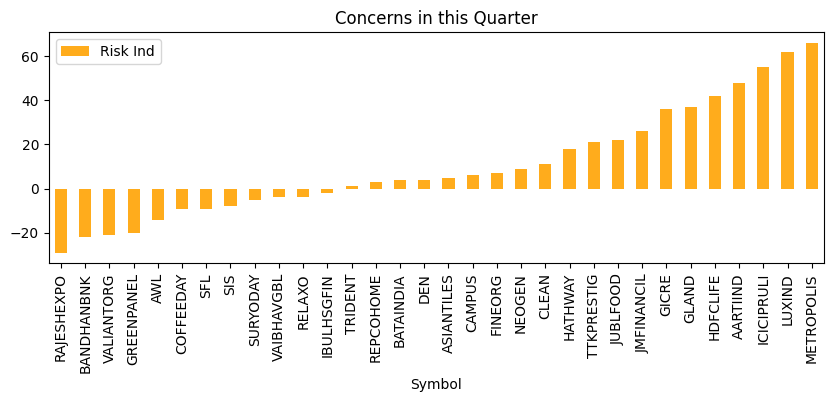

In [19]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)].sort_values(by = 'Risk Ind', ascending=True)
print('qualified stocks: '+str(tmp_df.shape[0]))
tmp_df.plot.bar(y='Risk Ind', x = 'Symbol',  figsize=(10, 3), color='#FFAC1C', title='Concerns in this Quarter')

In [20]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Symbol',  figsize=(10, 3), color='#4CBB17', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Symbol', figsize=(10, 3), color='#FFAC1C', title='Bottom 5 in ' + column, ax=ax2)

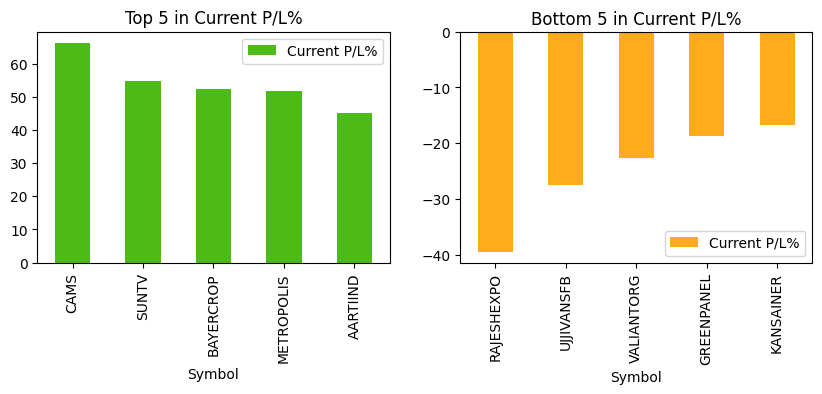

In [21]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

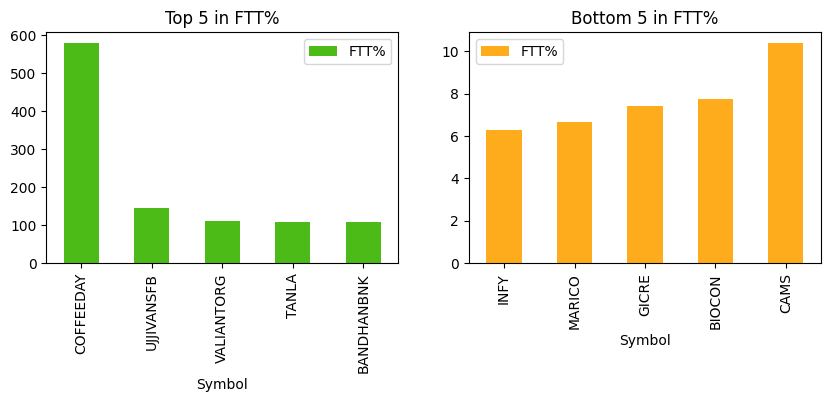

In [22]:
col = 'FTT%'
plot_features_top_bottom(df_portfolio_features, col)

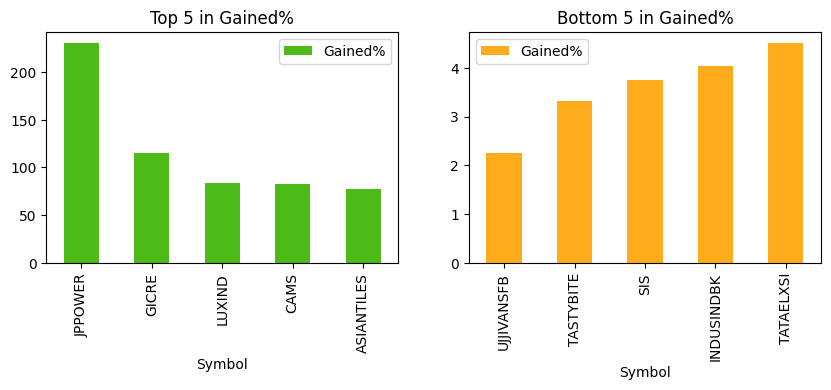

In [23]:
col = 'Gained%'
plot_features_top_bottom(df_portfolio_features, col)

In [24]:
#col = 'RSI_14'
#plot_features_top_bottom(df_portfolio_features, col)

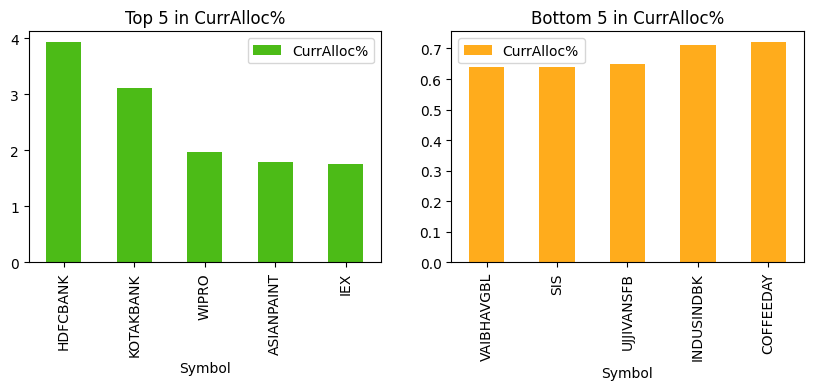

In [25]:
col = 'CurrAlloc%'
plot_features_top_bottom(df_portfolio_features, col)

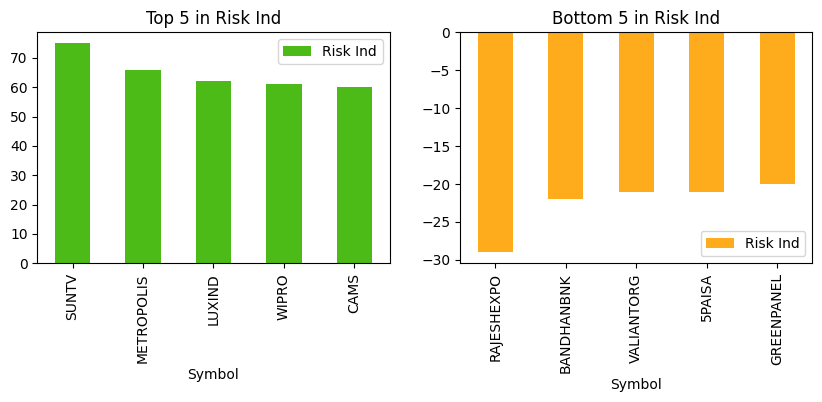

In [26]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [27]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['CurrAlloc%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'CurrAlloc%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'CurrAlloc%', ascending=False)
  tmp_df.plot.pie(y='CurrAlloc%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='CurrAlloc% in ' + column)

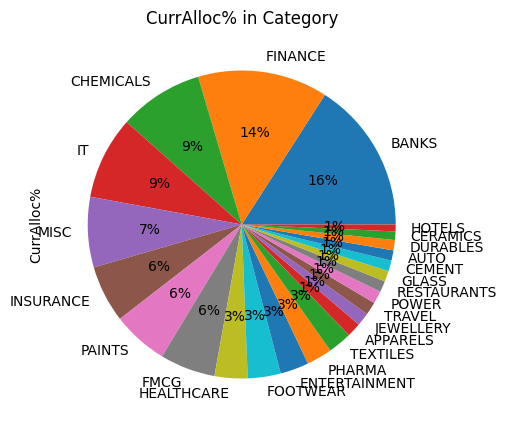

In [28]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

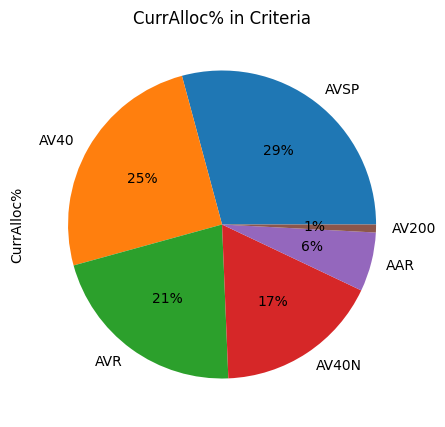

In [29]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

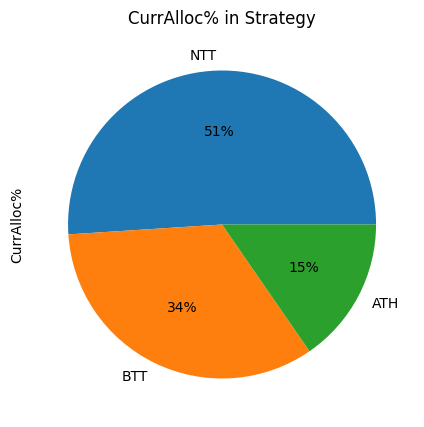

In [30]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

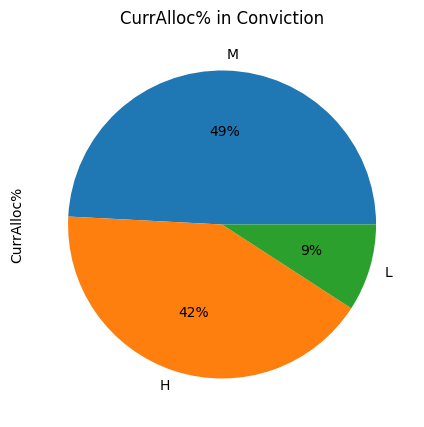

In [31]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [32]:
# stocks to extend in SV account

df_data = df_portfolio_features[~df_portfolio_features["Symbol"].isin(sv_pf['Symbol'].values)]
data_table.DataTable(df_data, include_index=False)


,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
49,MARICO,679.75,530.08,725.00,23.82,18.59,UP,200,135950.0,29934.0,...,1.21,3.31,AV40,BTT,34.0,38.71,1,1,H,FMCG
19,CAMS,4031.75,2424.02,4450.00,33.59,28.18,UP,25,100794.0,40194.0,...,0.90,3.85,AVR,BTT,60.0,82.38,1,1,M,MISC
39,INFY,1878.90,1436.24,1997.00,23.29,12.03,UP,104,195406.0,46037.0,...,1.74,3.75,AV40,BTT,54.0,42.78,1,1,H,IT
30,HCLTECH,1635.35,1349.00,1821.00,15.00,38.18,UP,75,122651.0,21476.0,...,1.09,1.54,AV40,BTT,23.0,53.96,1,1,H,IT
52,NEOGEN,1626.05,1489.90,1901.29,9.28,74.37,NaN,68,110571.0,9258.0,...,0.99,0.49,AAR,ATH,9.0,36.16,1,0,L,CHEMICALS
65,SONACOMS,690.25,578.05,800.00,11.51,5.70,UP,175,120794.0,19635.0,...,1.08,1.02,AAR,NTT,21.0,36.27,1,1,M,AUTO
35,ICICIPRULI,724.90,508.03,828.00,28.99,55.92,UP,198,143530.0,42940.0,...,1.28,2.10,AV40,BTT,55.0,51.35,1,0,H,INSURANCE
47,LTIM,5788.45,5051.49,7286.80,9.96,21.63,NaN,16,92615.0,11791.0,...,0.83,0.49,AV200,ATH,12.0,27.14,1,1,M,IT
76,UTIAMC,1051.40,946.90,1207.00,20.71,-13.37,UP,158,166121.0,16511.0,...,1.48,0.67,AVSP,NTT,16.0,45.33,1,1,M,FINANCE
14,BAYERCROP,6622.50,4346.57,8325.00,17.96,15.82,UP,16,105960.0,36415.0,...,0.95,1.34,AV40N,BTT,50.0,55.66,1,1,M,CHEMICALS


In [33]:
# stocks to extend in DM account

df_data = df_portfolio_features[~df_portfolio_features["Symbol"].isin(dm_pf['Symbol'].values)]
data_table.DataTable(df_data, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,Momentum,Shares,Current,Current P/L,...,CurrAlloc%,RRR Ind,Criteria,Strategy,Risk Ind,Gained%,LatestQtr,StarStock,Conviction,Category
22,DABUR,632.45,523.35,710.00,15.41,10.55,UP,175,110679.0,19093.0,...,0.99,1.41,AV40,BTT,21.0,28.26,1,1,H,FMCG
16,BIOCON,368.50,291.09,397.00,31.61,-11.61,UP,516,190146.0,39944.0,...,1.70,2.72,AVSP,NTT,45.0,68.73,1,1,H,PHARMA
46,LALPATHLAB,3078.55,2519.90,3689.00,22.31,1.82,UP,36,110828.0,20112.0,...,0.99,0.92,AV40N,NTT,22.0,53.41,1,1,M,HEALTHCARE
29,HATHWAY,23.92,19.74,31.40,8.73,82.63,UP,4000,95680.0,16720.0,...,0.85,0.56,AVR,NTT,18.0,52.36,1,0,M,ENTERTAINMENT
23,DEN,55.46,52.79,75.00,2.70,4.24,UP,1600,88736.0,4272.0,...,0.79,0.14,AAR,NTT,4.0,36.43,1,0,L,ENTERTAINMENT
1,AARTIIND,707.45,487.04,919.00,13.01,85.43,UP,167,118144.0,36808.0,...,1.05,1.04,AVR,NTT,48.0,60.09,1,0,M,CHEMICALS
40,IRCTC,984.15,904.87,1269.00,8.87,1.63,UP,156,153527.0,12367.0,...,1.37,0.28,AVSP,BTT,12.0,57.11,1,1,H,TRAVEL
71,TATAELXSI,6961.60,7332.28,10499.44,-8.68,-7.16,NaN,14,97462.0,-5190.0,...,0.87,-0.10,AV40N,ATH,-4.0,4.51,1,1,M,IT
50,MASFIN,289.60,326.60,470.00,-3.47,-17.79,NaN,300,86880.0,-11100.0,...,0.77,-0.21,AVR,BTT,-9.0,14.86,1,1,L,FINANCE
44,KANSAINER,275.30,330.73,437.59,-7.93,-66.39,DOWN,362,99659.0,-20065.0,...,0.89,-0.34,AV40N,ATH,-15.0,6.91,1,1,M,PAINTS


In [34]:
# notebook execution time

end_time = time.time()
execution_time = round(end_time - start_time, 0)
print(f"Notebook execution time: {execution_time} seconds")

Notebook execution time: 34.0 seconds
